# Text Summarization using deep learning

## Project Intro 
Text summarization is the process of taking a larger text and condensing it into the components which elicit the most useful information. While certain techinques such as TF-IDF and Naive Bayes can identify patterns and consistencies, they fail at remembering word order. Because of this, these techiniques can't make use of the context in which the words are said and lose vital information with regard to context. Deep learning models are capable of remembering word placement and can create more comprehensive summaries.

In [2]:
import pandas as pd
import numpy as np
import re
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

## The Data:
The Wikihow dataset was compiled with the purpose of it being used for abstract text summarization. Most text summarization datasets come from news articles, which are written in a style that places the most important facts in the beginning of the text. This makes it easy for summarization models to be out performed by simply taking the first few setences of these texts. The WikiHow dataset is written by regular people and contains procedural steps for completing a task. This means that the text summarization model will have to look for the details throughout the entire text in order to create an accurate summary. The dataset contains three rows: The headline (which will act as the target summary), the article title, and the article text.

In [3]:
# Importing the data
Data = pd.read_csv('Data/wikihowAll.csv', nrows = 40000)
Data.head()

,headline,title,text
0,"\r\nKeep related supplies in the same area.,\r...",How to Be an Organized Artist1,"If you're a photographer, keep all the necess..."
1,\r\nCreate a sketch in the NeoPopRealist manne...,How to Create a Neopoprealist Art Work,See the image for how this drawing develops s...
2,"\r\nGet a bachelor’s degree.,\r\nEnroll in a s...",How to Be a Visual Effects Artist1,It is possible to become a VFX artist without...
3,\r\nStart with some experience or interest in ...,How to Become an Art Investor,The best art investors do their research on t...
4,"\r\nKeep your reference materials, sketches, a...",How to Be an Organized Artist2,"As you start planning for a project or work, ..."


## Cleaning
In order to prepare this data for training, both the text and headline columns need to be cleaned so that they can be processed by a text tokenizer. In the following cells I perform text processing tasks such as expanding contractions, removing stopwords, and removing unwanted symbols and word endings. I then add these proccessed columns to the dataset as clean versions of their originals.

In [20]:
Data = Data.dropna(axis = 0)

Data.isna().sum()

headline    0
title       0
text        0
dtype: int64

In [21]:
# listing both the headlines 
all_entries = list(Data.text)
all_headlines = list(Data.headline)

In [5]:
# contraction dictionary for contraction expansion
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [16]:
Data['headline'].dtype

dtype('O')

In [17]:
# this function applies string functions to make the text readable
stop_words = set(stopwords.words('english'))
def clean_text(text):
    text = str(text)
    text = text.lower()
    text = re.sub(r'\([^)]*\)', '', text)
    text = text.replace('"', '')
    text = " ".join([contractions[word] if word in contractions else word for word in text.split(' ')])
    text = re.sub(r"'s\b", "", text)
    text = re.sub(r"[^a-zA-Z]", " ", text)
    tokens = [word for word in text.split() if word not in stop_words]
    long_words = []
    for word in tokens:
        if len(word) >= 3:
            long_words.append(word)
    return (" ".join(long_words)).strip()

In [18]:
def clean_headline(text):
    text = str(text)
    text = text.lower()
    text = re.sub(r'\([^)]*\)', '', text)
    text = text.replace('"', '')
    text = " ".join([contractions[word] if word in contractions else word for word in text.split(' ')])
    text = re.sub(r"'s\b", "", text)
    text = re.sub(r"[^a-zA-Z]", " ", text)
    tokens = text.split()
    long_words = []
    text = ''
    for word in tokens:
        if len(word) > 1:
            text=text+word+' '
    return text

In [22]:
# adding clean versions of text and headlines to dataframe
cleaned_entries = []
cleaned_headlines = []

for entry in all_entries:
    cleaned_entries.append(clean_text(entry))
for headline in all_headlines:
    cleaned_headlines.append(clean_headline(headline))
    
Data['clean_text'] = cleaned_entries
Data['cleaned_headline'] = cleaned_headlines

In [23]:
Data['cleaned_headline'] = Data['cleaned_headline'].apply(lambda x: '_START_ ' + x + ' _END_' )

In [24]:
Data.head()

,headline,title,text,clean_text,cleaned_headline
0,"\r\nKeep related supplies in the same area.,\r...",How to Be an Organized Artist1,"If you're a photographer, keep all the necess...",photographer keep necessary lens cords batteri...,_START_ keep related supplies in the same area...
1,\r\nCreate a sketch in the NeoPopRealist manne...,How to Create a Neopoprealist Art Work,See the image for how this drawing develops s...,see image drawing develops step step however i...,_START_ create sketch in the neopoprealist man...
2,"\r\nGet a bachelor’s degree.,\r\nEnroll in a s...",How to Be a Visual Effects Artist1,It is possible to become a VFX artist without...,possible become vfx artist without college deg...,_START_ get bachelor degree enroll in studio b...
3,\r\nStart with some experience or interest in ...,How to Become an Art Investor,The best art investors do their research on t...,best art investors research pieces art buy som...,_START_ start with some experience or interest...
4,"\r\nKeep your reference materials, sketches, a...",How to Be an Organized Artist2,"As you start planning for a project or work, ...",start planning project work likely gathering s...,_START_ keep your reference materials sketches...


## EDA

In order to choose the maximum sequence lengths for the models, I create histograms representing the various lengths of each text and headline. Larger sequences lengths can capture more information for inference but make the model take more time to process. The max length has to be set a one value for each of the texts for the model to run. Any text that has a smaller sequence length than the max length will be padded with zeros which will provide no further information but increase processing time. Texts with lengths above the sequence length won't include texts above the length and that information will be lost. Therefore the optimal sequence length will balance these issues.

In [25]:
text_word_count = []
headline_word_count = []

for text in Data['clean_text']:
    text_word_count.append(len(text.split()))
    
for headline in Data['cleaned_headline']:
    headline_word_count.append(len(headline.split()))

In [35]:
zip(Data['clean_text'], Data['cleaned_headline'])

In [36]:
texts_under_250 = []
headline_250 = []


for text, headline in zip(Data['clean_text'], Data['cleaned_headline']):
    if len(text.split()) <= 250:
        texts_under_250.append(text)
        headline_250.append(headline)
    

In [38]:
len(texts_under_250)
len(headline_250)

25999

In [26]:
np.mean(text_word_count)

258.48897891399525

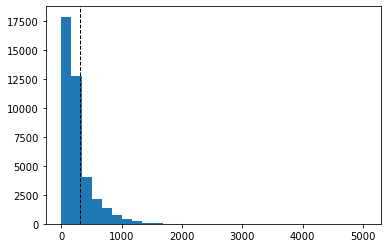

In [27]:
plt.hist(text_word_count, bins = 30)
plt.axvline(np.quantile(text_word_count,.75), color='k', linestyle='dashed', linewidth=1)

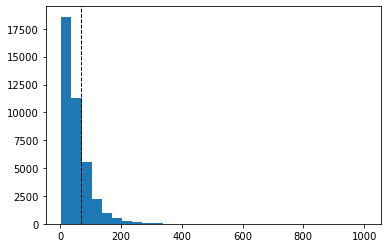

In [28]:
plt.hist(headline_word_count, bins = 30)
plt.axvline(np.quantile(headline_word_count, .75), color='k', linestyle='dashed', linewidth=1)
plt.savefig('images/headline_histogram1')

In [29]:
max_len_text = int(np.quantile(text_word_count, .75))
max_len_headline = int(np.quantile(headline_word_count, .75))
print(max_len_text)
print(max_len_headline)

316
69


## Insights and Next Steps
The data here shows that 75 percentile for texts are at 316 and 69 for the texts and headlines respectively. Based on this I will round up to 30 and 70 when creating the model. The next step is to preprocess and develop the model so that it can be trained and validated. 

In [31]:
# Saving the data
Data.to_csv('Data/Wikihow_clean_')